First, we need to import some modules. These are collections of code already written that we can use in our scripts:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import astropy.units as u
import astropy.constants as const

%matplotlib notebook

In [2]:
#Define some physical constants we'll use later
G_const = 6.674e-11 #gravitational constant, units m^3 / kg / s^2
AU = 1.495e11 #astronomical unit (Earth-Sun distance), units m

dt = 60 * 60 * 24 #length of one time-step, in seconds. Here we use one Earth-day
num_steps = 100000 #total number of steps to evalulate. 10 000 steps of 1 day each ~ 30 years

In [3]:
def calc_orbit_speed(radius,M_central):
    return np.sqrt(G_const * M_central / (radius * AU))

In [4]:
calc_orbit_speed(1,1.99e30)

29805.68058806451

Now we need to store some data about the objects in our Solar System so we can add them to our simulation. We use a data structure called a 'dictionary'.

In [5]:
solar_system = {'Sun':{
                    'mass':1.988e30,
                    'orbit_radius':0,
                    'colour':'yellow'
                },
                'Earth':{
                    'mass':5.97e24,
                    'orbit_radius':1,
                    'colour':'forestgreen'
                },
                 'Mercury':{
                    'mass':3.30e23,
                    'orbit_radius':0.39,
                    'colour':'teal'
                },
                 'Venus' :{
                     'mass':4.87e24,
                     'orbit_radius':0.72,
                     'colour':'goldenrod'
                },
                  'Mars':{
                     'mass':6.42e23,
                     'orbit_radius':1.52,
                     'colour':'darkred'
                },
                 'Jupiter':{
                     'mass':1.90e27,
                     'orbit_radius':5.19,
                     'colour':'peru'
                },
                'Saturn':{
                    'mass':5.68e26,
                    'orbit_radius':9.33,
                    'colour':'peachpuff'
                },
                'Uranus':{
                    'mass':8.68e25,
                    'orbit_radius':19.33,
                    'colour':'lightblue'
                },
                'Neptune':{
                    'mass':1.02e26,
                    'orbit_radius':30.00,
                    'colour':'cadetblue'
                },
                'Pluto':{
                    'mass':1.31e22,
                    'orbit_radius':49.00,
                    'colour':'burlywood'
                },
                'Halley':{
                    'mass':2.2e14,
                    'orbit_radius':35.00,
                    'colour':'rebeccapurple'}}
               
                      
                
               

In [6]:
solar_system['Sun']['mass']

1.988e+30

In [7]:
np.random.seed(7)

print(np.random.random()*360)
print(np.random.random()*360)

27.470984174624583
280.77076520644124


Now we have the basic information about each planet in the Solar System, we can add more information to our dictionary:

In [8]:
for body in list(solar_system.keys()): #loop over every planet in our dictionary
    theta = np.random.random() * 360
    
    distance = solar_system[body]['orbit_radius']
    solar_system[body]['xs'] = [distance * np.cos(np.deg2rad(theta))] #set the starting location of the planet
    solar_system[body]['ys'] = [distance * np.sin(np.deg2rad(theta))]

    #now we can calculate the orbital velocity of each planet around the Sun, assuming a circular orbit
    
    if body == 'Sun': #we skip the Sun because it can't orbit itself!
        orbit_v = 0 #the Sun will start stationary
    else: #every planet
        
        #call the earlier function we wrote to calculate the orbital speed
        orbit_v = calc_orbit_speed(solar_system[body]['orbit_radius'],solar_system['Sun']['mass'])
        
    solar_system[body]['xs_vel'] = [orbit_v* -1*np.sin(np.deg2rad(theta))]
    solar_system[body]['ys_vel'] = [orbit_v *np.cos(np.deg2rad(theta))]  #add this initial speed to the dictionary


For fun, we can manually edit some of the values we just calculated, for example by slowing the Earth down

In [9]:
solar_system['Pluto']['ys_vel'][0] *= 0.89 #this will slow the Earth down by 20% - let's see what will happen!
#solar_system['Sun']['xs_vel'][0] = 1e3  #makes the Sun move slowly
solar_system['Halley']['ys_vel'][0] *= 0.2
#solar_system['Earth']['mass'] = 2e30

Now we're going to calculate the movement of all the planets!

For each timestep (of 1 day) will we calculate the acceleration felt by each planet and use this to update its velocity and position.

In [10]:
for i in range(num_steps): #loop over each timestep
    for body in list(solar_system.keys()): #loop over every body in the Solar System
        x_pos, y_pos = solar_system[body]['xs'][i], solar_system[body]['ys'][i] #look-up the current position
        x_vel, y_vel = solar_system[body]['xs_vel'][i], solar_system[body]['ys_vel'][i] #look-up the current velocity

        x_accel, y_accel = 0, 0 #reset the acceleration to zero
        
        for body_compare in list(solar_system.keys()): #now we compare every body to every other body
            if body_compare != body: #don't compare to itself!
                x_rad = x_pos - solar_system[body_compare]['xs'][i] #x-distance between the bodies
                y_rad = y_pos - solar_system[body_compare]['ys'][i] #y-distance between the bodies
                
                total_rad = np.sqrt(x_rad**2 + y_rad**2) #total distance between the bodies
            
                #use the gravity equation to calculate the acceleration felt due to this body
                x_accel = x_accel - (x_rad * AU) * G_const * solar_system[body_compare]['mass'] / (total_rad * AU)**3
                y_accel = y_accel - (y_rad * AU) * G_const * solar_system[body_compare]['mass'] / (total_rad * AU)**3

        x_vel = x_vel + x_accel * dt #calculate the new velocity
        y_vel = y_vel + y_accel * dt

        x_pos = x_pos + (x_vel * dt) / AU #calculate the new position
        y_pos = y_pos + (y_vel * dt) / AU

        solar_system[body]['xs'].append(x_pos) #update the dictionary with the new position
        solar_system[body]['ys'].append(y_pos)
        
        solar_system[body]['xs_vel'].append(x_vel) #update the dictionary with the new velocity
        solar_system[body]['ys_vel'].append(y_vel)
        

Now we have all the data, let's display it!

<IPython.core.display.Javascript object>


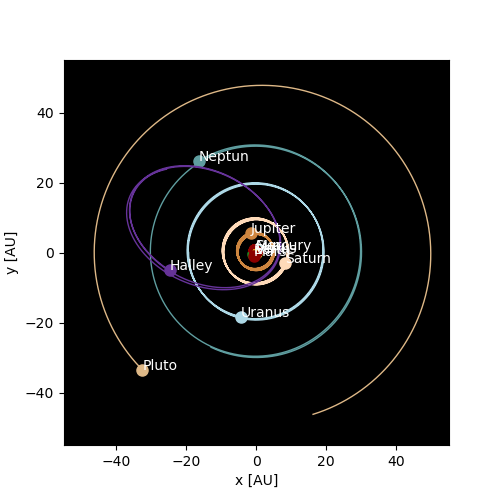

In [11]:
fig, ax = plt.subplots(figsize=(5,5)) #set up the figure
ax.set_aspect('equal')
max_rad = 1

#now we need to initialise the objects we want to draw

for body in list(solar_system.keys()):
    x_init, y_init = solar_system[body]['xs'][0], solar_system[body]['ys'][0]
    
    line,     = ax.plot([],[],'-',lw=1,c=solar_system[body]['colour']) #a line tracing the orbit
    point,    = ax.plot(x_init, y_init, marker="o"
                      , markersize=8
                      , markeredgecolor=solar_system[body]['colour']
                      , markerfacecolor=solar_system[body]['colour']) #a point marking the current position
    text      = ax.text(x_init, y_init, body, c='w') #a label for the planet
    
    #now we can add these drawing objects to the dictionary
    solar_system[body]['line'] = line
    solar_system[body]['point'] = point
    solar_system[body]['text'] = text
    
    max_rad = max(solar_system[body]['orbit_radius'], max_rad) #calculate the maximum bounds of the figure
                       
                     
plot_rad = max_rad * 1.2 
plot_rad = 55


ax.set_xlim(-plot_rad,plot_rad)
ax.set_ylim(-plot_rad,plot_rad) #set the maximum bounds of the figure

ax.set_xlabel('x [AU]') #set axis labels
ax.set_ylabel('y [AU]')

ax.set_facecolor('k') #background colour

skip_frames = 100


#we will create a function that plots each timestep
def update(i):
    frame = i * skip_frames
    for body in list(solar_system.keys()):
        #retrieve the position of each planet at the current timestep
        x_pos, y_pos = solar_system[body]['xs'][frame], solar_system[body]['ys'][frame]
        
        #update the position of each drawing object
        solar_system[body]['line'].set_data(solar_system[body]['xs'][0:frame],solar_system[body]['ys'][0:frame])
        solar_system[body]['point'].set_data(x_pos,y_pos)
        solar_system[body]['text'].set_position((x_pos,y_pos))
    return


time_interval = 5 #length of each frame in miliseconds

#use this animation function to call our 'update' function repeatedly
anim = animation.FuncAnimation(fig
                                ,func=update
                                ,frames=num_steps
                                ,interval=time_interval
                                ,blit=True)
plt.show() #display the figure!

In [12]:
list(solar_system.keys())


108.2 * 1e6 * 1e3 / AU

print(solar_system['Earth']['ys_vel'][0])

-4943.8227328914
